# Exploring Single Neuron Excitability with Mathematical and Computational Models Computer lab 2
## Brian2 and Model Fitting
##### Nils Koch and Niklas Brake

Example of Izhekevich model implmentation in Brian 2 and exploration of model fitting


# 1. Brain2


## Izhekevich model implemented in brian2


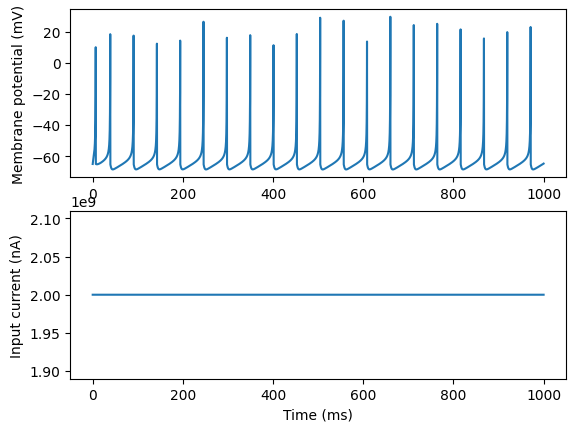

In [1]:
import brian2
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import brian2
from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
from brian2 import ms, mV, nA
from brian2 import defaultclock, run

brian2.start_scope()
# Define the Izhekevich model equations
eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

# Create a neuron group with a single neuron using the model and parameters
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# Set the parameters for the model
neuron.a = 0.02
neuron.b = 0.25
neuron.c = -65
neuron.d = 2

# Define the initial conditions for the model
v0 = -70 * mV
u0 = neuron.b * v0/ms

# Set the initial values for the neuron's membrane potential and recovery variable
neuron.v = -65
neuron.u = "b*v"

# Set the input current for the neuron
input_current = 2 # nA
neuron.I = input_current

# Create a monitor to record the neuron's membrane potential and input current
monitors = StateMonitor(neuron, ['v', 'I'], record=True)

# Run the simulation for 100 milliseconds
dur = 1000 * ms
run(dur)

# Plot the neuron's membrane potential and input current over time
plt.figure()
plt.subplot(211)
plt.plot(monitors.t/ms, monitors.v[0])
plt.ylabel('Membrane potential (mV)')
plt.subplot(212)
plt.plot(monitors.t/ms, monitors.I[0]/nA)
plt.ylabel('Input current (nA)')
plt.xlabel('Time (ms)')
plt.show()


# 2. The Fitting Problem

# 3. Try fitting parameters to capture data

# Extra: Network of Izhekevich models

Create a network of spiking neurons
Adapted from https://brian2.readthedocs.io/en/stable/examples/frompapers.Izhikevich_2003.html based on http://izhikevich.org/publications/spikes.htm

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import brian2
# from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
# from brian2 import ms, mV
# from brian2 import defaultclock, run
brian2.start_scope()
tfinal = 1000 * ms
Ne = 800
Ni = 200

re = np.random.uniform(size=Ne)
ri = np.random.uniform(size=Ni)
weights = np.hstack(
    [
        0.5 * np.random.uniform(size=(Ne + Ni, Ne)),
        -np.random.uniform(size=(Ne + Ni, Ni)),
    ]
).T

defaultclock.dt = 1 * ms

eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         I_noise : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
N.v = -65

N_exc = N[:Ne]
N_inh = N[Ne:]

spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N_exc.a = 0.02
N_exc.b = 0.2
N_exc.c = -65 + 15 * re**2
N_exc.d = 8 - 6 * re**2

N_inh.a = 0.02 + 0.08 * ri
N_inh.b = 0.25 - 0.05 * ri
N_inh.c = -65
N_inh.d = 2

N_exc.u = "b*v"
N_inh.u = "b*v"

S = Synapses(
    N,
    N,
    "w : 1",
    on_pre={"up": "I += w", "down": "I -= w"},
    delay={"up": 0 * ms, "down": 1 * ms},
)
S.connect()
S.w[:] = weights.flatten()


# Run abstract code in the group’s namespace.
# The created CodeRunner object will be automatically added to the group, it therefore does not need to be added to the network manually. However, a reference to the object will be returned, which can be used to later remove it from the group or to set it to inactive.
N_exc.run_regularly("I_noise = 5*randn()", dt=1 * ms)
N_inh.run_regularly("I_noise = 2*randn()", dt=1 * ms)

run(tfinal)

fig, (ax, ax_voltage) = plt.subplots(2, 1, sharex=True,
                                     gridspec_kw={'height_ratios': (3, 1)})

ax.scatter(spikemon.t / ms, spikemon.i[:], marker="_", color="k", s=10)
ax.set_xlim(0, tfinal / ms)
ax.set_ylim(0, len(N))
ax.set_ylabel("neuron number")
ax.set_yticks(np.arange(0, len(N), 100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(Ne, color="k")
ax.text(500, 900, 'inhibitory', backgroundcolor='w', color='k', ha='center')
ax.text(500, 400, 'excitatory', backgroundcolor='w', color='k', ha='center')

ax_voltage.plot(statemon.t / ms, np.clip(statemon.v[0], -np.inf, 30),
               color='k')
ax_voltage.text(25, 0, 'v₁(t)')
ax_voltage.set_xticks(np.arange(0, tfinal / ms, 100))
ax_voltage.spines['right'].set_visible(False)
ax_voltage.spines['top'].set_visible(False)
ax_voltage.set_xlabel("time, ms")

plt.show()